# iBus - Detecção de Pessoas em Ônibus

⚠️ **AVISO:** Este é o notebook original (legado). Para projetos reais, utilize a **versão modular** disponível em `ibus_ai/`.  
📚 Consulte `README.md` e `GUIA_DE_ESTUDO.md` para documentação completa.

---

Este projeto desenvolve um sistema de **detecção e contagem de pessoas em ambientes internos de ônibus** utilizando técnicas clássicas de Visão Computacional, **sem usar modelos pré-treinados**.

O sistema implementa um pipeline completo desde a preparação do dataset até a detecção final, incluindo extração de características (HOG), classificação (SVM) e refinamento de detecções (NMS).

## 1. Requisitos do Dataset

### Objetivo:
Definir as necessidades de um dataset para detecção de pessoas em ônibus.

### O que precisamos:
- Imagens de interiores de ônibus
- Anotações de pessoas (caixas delimitadoras) ou contagem total
- Variações de iluminação, ocupação e tipos de ônibus

### Especificações do Dataset

Um dataset de qualidade é fundamental para treinar o modelo. Sem modelos pré-treinados, precisamos de dados específicos e bem anotados.

#### 📸 Requisitos das Imagens:

**Variações necessárias:**
- **Iluminação:** Diferentes horários (manhã, tarde, noite) e condições (natural, artificial, sombras)
- **Tipos de Ônibus:** Diferentes modelos e layouts de interiores
- **Ocupação:** Baixa, média e alta ocupação de passageiros
- **Qualidade:** Resolução adequada para visualizar detalhes das pessoas

#### 🏷️ Anotações Necessárias:

1. **Caixas Delimitadoras:** Retângulos precisos ao redor de cada pessoa
2. **Contagem Total:** Número exato de pessoas por imagem

#### 🎯 Diversidade Importante:

- **Poses:** Sentados, em pé, inclinados, de costas, de perfil
- **Oclusões:** Pessoas parcialmente visíveis (cobertas por outras ou objetos)
- **Aparência:** Diferentes roupas, acessórios e características físicas
- **Escala:** Pessoas em diferentes distâncias da câmera

**Conclusão:** Um dataset diverso permite treinar um modelo robusto capaz de lidar com variações do mundo real.

## 2. Carregar e Pré-processar Imagens

### Objetivo:
Carregar imagens e aplicar pré-processamento padrão para preparar os dados.

### Preparação

Primeiro, importar as bibliotecas necessárias e criar uma imagem dummy para demonstração.

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Criar uma imagem dummy para demonstração
caminho_imagem_dummy = "imagem_dummy.png"

# Criar imagem RGB simples de 50x50 pixels
dados_imagem_dummy = np.random.randint(0, 256, (50, 50, 3), dtype=np.uint8)
imagem_dummy = Image.fromarray(dados_imagem_dummy)
imagem_dummy.save(caminho_imagem_dummy)

print(f"✓ Imagem dummy salva em: {caminho_imagem_dummy}")

# Lista de caminhos de imagens
caminhos_imagens = [caminho_imagem_dummy]

: 

### Pipeline de Pré-processamento

Aplicar as etapas: redimensionar, converter para escala de cinza e normalizar.

In [ ]:
imagens_carregadas = []
imagens_preprocessadas = []

# Tamanho alvo para redimensionamento
tamanho_alvo = (256, 256)

# Pipeline de pré-processamento
for caminho in caminhos_imagens:
    # 1. Carregar imagem
    img = Image.open(caminho)
    imagens_carregadas.append(img)
    
    # 2. Redimensionar para dimensões consistentes
    img_redimensionada = img.resize(tamanho_alvo)
    
    # 3. Converter para escala de cinza
    img_cinza = img_redimensionada.convert('L')  # 'L' = grayscale
    
    # 4. Converter para array numpy e normalizar (0-1)
    img_array = np.array(img_cinza, dtype=np.float32) / 255.0
    imagens_preprocessadas.append(img_array)

print(f"✓ {len(imagens_carregadas)} imagem(ns) carregada(s)")
print(f"✓ {len(imagens_preprocessadas)} imagem(ns) pré-processada(s)")

# Exibir imagem pré-processada
if imagens_preprocessadas:
    plt.figure(figsize=(4, 4))
    plt.imshow(imagens_preprocessadas[0], cmap='gray')
    plt.title("Imagem Pré-processada (Cinza, Normalizada)")
    plt.axis('off')
    plt.show()
else:
    print("Nenhuma imagem foi pré-processada.")

# Limpar arquivo dummy
os.remove(caminho_imagem_dummy)
print(f"✓ Imagem dummy removida: {caminho_imagem_dummy}")

## 3. Extração de Características Básicas

### Objetivo:
Aplicar técnicas de extração de características (detecção de bordas, cantos e histogramas) nas imagens pré-processadas.

### Aplicar Detectores

Usar OpenCV para detectar bordas (Canny), cantos (Harris) e calcular histograma de intensidade.

In [ ]:
import cv2

if not imagens_preprocessadas:
    print("Erro: Nenhuma imagem pré-processada disponível. Execute as células anteriores.")
else:
    # Selecionar primeira imagem pré-processada
    imagem_amostra = imagens_preprocessadas[0]
    
    # Converter para uint8 (0-255) para funções do OpenCV
    imagem_uint8 = (imagem_amostra * 255).astype(np.uint8)
    
    # 1. Detecção de Bordas Canny
    bordas = cv2.Canny(imagem_uint8, 50, 150)
    
    # 2. Detecção de Cantos Harris
    resposta_cantos = cv2.cornerHarris(imagem_amostra, 2, 3, 0.04)
    cantos_dilatados = cv2.dilate(resposta_cantos, None)
    
    # Marcar cantos em vermelho
    imagem_cantos = np.stack([imagem_uint8, imagem_uint8, imagem_uint8], axis=-1)
    imagem_cantos[cantos_dilatados > 0.01 * cantos_dilatados.max()] = [0, 0, 255]
    
    # 3. Calcular Histograma de Intensidade
    histograma = cv2.calcHist([imagem_uint8], [0], None, [256], [0, 256])
    
    # Visualizar resultados
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(imagem_amostra, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(bordas, cmap='gray')
    plt.title('Bordas Canny')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(imagem_cantos, cv2.COLOR_BGR2RGB))
    plt.title('Cantos Harris')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.plot(histograma)
    plt.title('Histograma de Intensidade')
    plt.xlabel('Valor do Pixel')
    plt.ylabel('Frequência')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 4. Conceito: Heurísticas de Contagem

### Objetivo:
Propor abordagens heurísticas simples para contar pessoas baseadas nas características extraídas.

**Nota:** Esta seção é apenas conceitual. Para implementação prática, consulte os módulos em `ibus_ai/`.

### Heurísticas Propostas

#### Como usar as características:

**Bordas Canny:**
- Contornos curvas e fechadas → silhuetas de pessoas
- Alta densidade de bordas → regiões com detalhes (roupas, rostos)

**Cantos Harris:**
- Aglomerados de cantos → articulações, características faciais
- Distribuição de cantos → diferencia textura complexa de fundo liso

**Histogramas:**
- Diferenciação pessoa/fundo → faixas de intensidade características
- Normalização de iluminação → robustez a variações de luz

#### Abordagem Heurística:

1. **Segmentação por Bordas:** Agrupar bordas próximas em regiões
2. **Verificação por Cantos:** Regiões com densidade de cantos → candidatas a pessoas
3. **Filtro por Forma:** Eliminar regiões muito pequenas ou grandes
4. **Agrupamento:** Consolidar regiões adjacentes em detecções únicas

#### ⚠️ Limitações:

- Sensível a ruído e iluminação
- Sem compreensão semântica ("o que é pessoa?")
- Dificuldade com oclusões e variações
- Necessita dataset real anotado

### Resumo da Primeira Parte

**Principais Descobertas:**

✓ Dataset bem anotado é fundamental para treinamento  
✓ Pré-processamento padroniza as imagens (redimensionar, cinza, normalizar)  
✓ Características básicas (bordas, cantos, histograma) fornecem informação de baixo nível  
✓ Heurísticas simples têm limitações severas sem aprendizado de máquina  

**Próximos Passos:**

→ Usar características HOG (mais robustas)  
→ Treinar classificador SVM  
→ Implementar sliding window  
→ Aplicar NMS para refinar detecções

---

# PARTE 2: Implementação Prática

## 5. Carregar Imagem Real de Ônibus

**Objetivo:** Aplicar o pipeline em uma imagem real de interior de ônibus.

In [ ]:
# Caminho da imagem do ônibus (ajuste conforme necessário)
caminho_imagem_onibus = 'cameras-onibus.webp'

# Tamanho alvo para redimensionamento
tamanho_alvo = (256, 256)

imagens_preprocessadas_usuario = []

# Verificar se arquivo existe
if os.path.exists(caminho_imagem_onibus):
    # Carregar imagem
    img_usuario = Image.open(caminho_imagem_onibus)
    
    # Redimensionar
    img_redimensionada = img_usuario.resize(tamanho_alvo)
    
    # Converter para escala de cinza
    img_cinza = img_redimensionada.convert('L')
    
    # Normalizar (0-1)
    img_array = np.array(img_cinza, dtype=np.float32) / 255.0
    
    # Armazenar
    imagens_preprocessadas_usuario.append(img_array)
    
    print(f"✓ Imagem carregada e pré-processada: {caminho_imagem_onibus}")
    
    # Exibir
    plt.figure(figsize=(4, 4))
    plt.imshow(imagens_preprocessadas_usuario[0], cmap='gray')
    plt.title(f"Imagem do Ônibus (Pré-processada)")
    plt.axis('off')
    plt.show()
else:
    print(f"Arquivo não encontrado: {caminho_imagem_onibus}")
    print("Ajuste o caminho da imagem ou coloque o arquivo no diretório correto.")

Error: Image file not found at camera-onibus.webp. Please ensure the file is in the correct directory.


## 6. Extrair Características da Imagem do Ônibus

**Objetivo:** Aplicar detectores de bordas, cantos e histograma na imagem real.

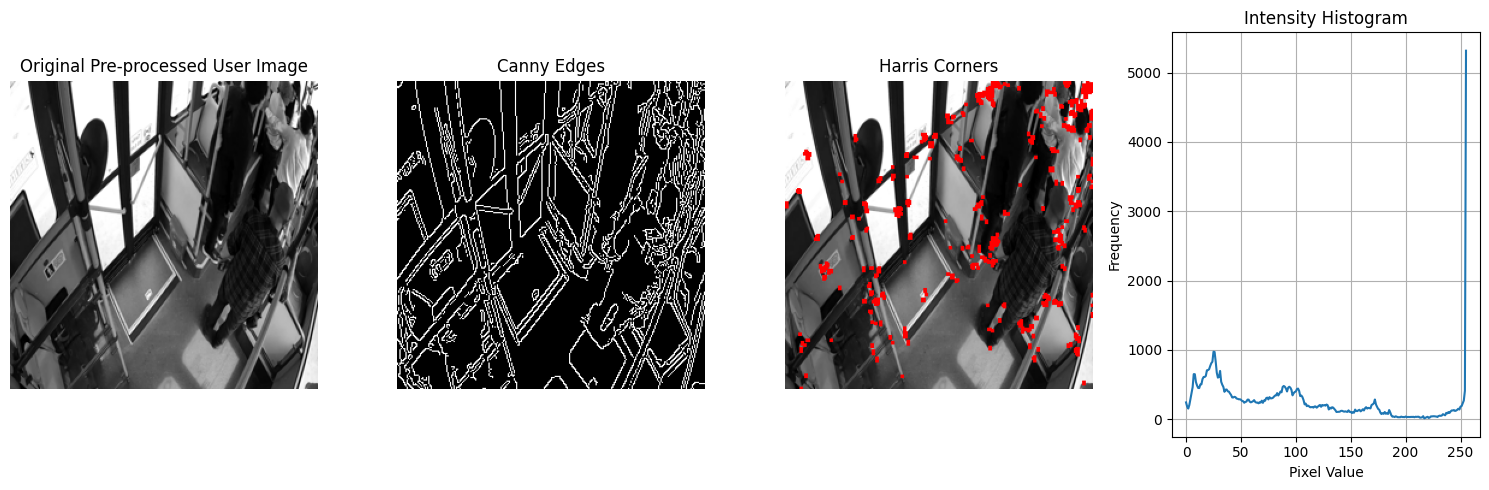

In [ ]:
if not imagens_preprocessadas_usuario:
    print("Nenhuma imagem do usuário disponível. Execute a célula anterior.")
else:
    # Selecionar imagem do ônibus
    imagem_onibus = imagens_preprocessadas_usuario[0]
    
    # Converter para uint8
    imagem_uint8 = (imagem_onibus * 255).astype(np.uint8)
    
    # Aplicar detectores
    bordas_canny = cv2.Canny(imagem_uint8, 50, 150)
    resposta_harris = cv2.cornerHarris(imagem_onibus, 2, 3, 0.04)
    cantos_dilatados = cv2.dilate(resposta_harris, None)
    
    # Marcar cantos
    imagem_cantos = np.stack([imagem_uint8, imagem_uint8, imagem_uint8], axis=-1)
    imagem_cantos[cantos_dilatados > 0.01 * cantos_dilatados.max()] = [0, 0, 255]
    
    # Calcular histograma
    histograma_intensidade = cv2.calcHist([imagem_uint8], [0], None, [256], [0, 256])
    
    # Visualizar
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(imagem_onibus, cmap='gray')
    plt.title('Imagem Original do Ônibus')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(bordas_canny, cmap='gray')
    plt.title('Bordas Canny')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(imagem_cantos, cv2.COLOR_BGR2RGB))
    plt.title('Cantos Harris')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.plot(histograma_intensidade)
    plt.title('Histograma de Intensidade')
    plt.xlabel('Valor do Pixel')
    plt.ylabel('Frequência')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 7. Treinamento 'Do Zero'

### Conceito: Como Treinar um Modelo sem Pré-treinados

#### 1️⃣ Anotação Manual
- Desenhar caixas delimitadoras ao redor de cada pessoa
- Define a "verdade fundamental" (ground truth)
- Exemplos positivos (pessoa) e negativos (não-pessoa)

#### 2️⃣ Características HOG (Histogram of Oriented Gradients)
- **O que é:** Descritor que captura gradientes de orientação
- **Como funciona:**
  1. Calcular gradientes (magnitude e direção)
  2. Dividir em células (ex: 8x8 pixels)
  3. Criar histograma de orientações por célula
  4. Normalizar por blocos (robustez a iluminação)
- **Por que funciona:** Captura forma e textura de pessoas

#### 3️⃣ Classificador SVM (Support Vector Machine)
- Aprende a separar "pessoa" vs "não-pessoa"
- Encontra hiperplano com margem máxima
- Eficaz em espaços de alta dimensão (HOG tem centenas de features)

#### 4️⃣ Sliding Window
- **Janela deslizante:** Move uma janela pela imagem
- **Multi-escala:** Testa em vários tamanhos (pessoas próximas/distantes)
- **Classificação:** Cada janela é classificada pelo SVM
- **Refinamento NMS:** Remove detecções redundantes

### Resumo dos Conceitos

**O que aprendemos:**

✓ **Características básicas** são blocos de construção, mas limitadas  
✓ **HOG** é muito mais robusto para detectar formas humanas  
✓ **Anotação manual** é essencial (sem ela, não há como treinar)  
✓ **SVM** aprende a distinguir pessoa/não-pessoa  
✓ **Sliding window** permite detectar em qualquer posição/escala  
✓ **NMS** consolida detecções sobrepostas  

**Limitação desta abordagem:**

⚠️ Dataset pequeno (poucos exemplos) → baixa generalização  
⚠️ Computacionalmente caro (sliding window testa milhares de janelas)  
⚠️ Sensível a variações (iluminação, oclusão, pose)  

**Para sistemas robustos:** Use deep learning (YOLO, Faster R-CNN) com milhares de imagens anotadas!

---

# PARTE 3: Implementação Prática com HOG e SVM

## 8. Definir Regiões de Interesse (ROIs)

**Objetivo:** Simular anotação manual definindo ROIs de "pessoa" e "não-pessoa".

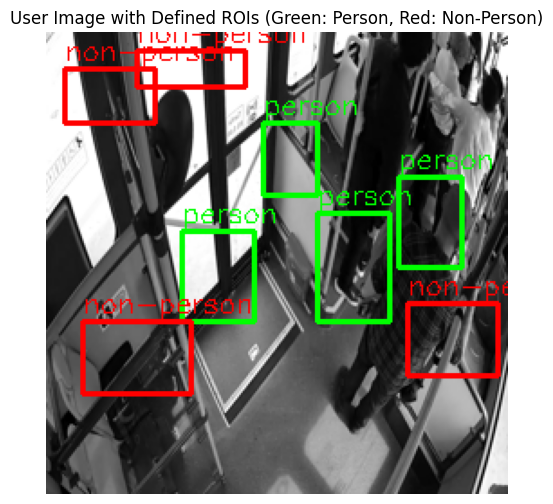

Defined 8 ROIs on the user image.


In [ ]:
if 'imagens_preprocessadas_usuario' not in locals() or not imagens_preprocessadas_usuario:
    print("⚠️ Nenhuma imagem do ônibus encontrada. Execute as células anteriores.")
else:
    imagem_onibus = imagens_preprocessadas_usuario[0]
    imagem_uint8 = (imagem_onibus * 255).astype(np.uint8)
    
    # Converter para BGR para desenhar em cores
    imagem_rois = cv2.cvtColor(imagem_uint8, cv2.COLOR_GRAY2BGR)
    
    # Definir ROIs manualmente (formato: x, y, largura, altura)
    rois = [
        # PESSOAS
        {'box': (75, 110, 40, 50), 'label': 'person'},    # Pessoa sentada
        {'box': (120, 50, 30, 40), 'label': 'person'},    # Cabeça de pessoa
        {'box': (150, 100, 40, 60), 'label': 'person'},   # Torso de pessoa
        {'box': (195, 80, 35, 50), 'label': 'person'},    # Outra pessoa
        
        # NÃO-PESSOAS (fundo, assentos, etc.)
        {'box': (20, 160, 60, 40), 'label': 'non-person'}, # Assento
        {'box': (200, 150, 50, 40), 'label': 'non-person'}, # Assento
        {'box': (10, 20, 50, 30), 'label': 'non-person'},  # Janela
        {'box': (50, 10, 60, 20), 'label': 'non-person'}   # Teto
    ]
    
    # Desenhar ROIs na imagem
    for roi in rois:
        x, y, w, h = roi['box']
        label = roi['label']
        
        # Verde para pessoa, Vermelho para não-pessoa (BGR)
        cor = (0, 255, 0) if label == 'person' else (0, 0, 255)
        
        # Desenhar retângulo
        cv2.rectangle(imagem_rois, (x, y), (x + w, y + h), cor, 2)
        
        # Adicionar texto
        texto = 'Pessoa' if label == 'person' else 'Não-Pessoa'
        cv2.putText(imagem_rois, texto, (x, y - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, cor, 1)
    
    # Exibir
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(imagem_rois, cv2.COLOR_BGR2RGB))
    plt.title('ROIs Definidas (Verde: Pessoa, Vermelho: Não-Pessoa)')
    plt.axis('off')
    plt.show()
    
    print(f"✓ {len(rois)} ROIs definidas:")
    print(f"  - Pessoas: {sum(1 for r in rois if r['label'] == 'person')}")
    print(f"  - Não-pessoas: {sum(1 for r in rois if r['label'] == 'non-person')}")

## 9. Extrair Características HOG das ROIs

**Objetivo:** Extrair vetores de características HOG de cada ROI para treinar o classificador.

In [ ]:
from skimage.feature import hog

# Parâmetros HOG
orientacoes = 9
pixels_por_celula = (8, 8)
celulas_por_bloco = (2, 2)

# Listas para armazenar características e rótulos
lista_caracteristicas_hog = []
lista_rotulos_hog = []

if 'imagens_preprocessadas_usuario' not in locals() or not imagens_preprocessadas_usuario:
    print("⚠️ Imagem do ônibus não disponível.")
elif 'rois' not in locals():
    print("⚠️ ROIs não definidas. Execute a célula anterior.")
else:
    imagem_onibus = imagens_preprocessadas_usuario[0]
    
    # Extrair HOG de cada ROI
    for roi in rois:
        x, y, w, h = roi['box']
        label = roi['label']
        
        # Extrair patch da imagem [y:y+h, x:x+w]
        patch = imagem_onibus[y : y + h, x : x + w]
        
        # Verificar se patch não está vazio
        if patch.shape[0] > 0 and patch.shape[1] > 0:
            # Extrair características HOG
            caracteristicas = hog(
                patch,
                orientations=orientacoes,
                pixels_per_cell=pixels_por_celula,
                cells_per_block=celulas_por_bloco,
                visualize=False
            )
            
            lista_caracteristicas_hog.append(caracteristicas)
            lista_rotulos_hog.append(label)
    
    # Exibir contagem
    contagem_pessoa = lista_rotulos_hog.count('person')
    contagem_nao_pessoa = lista_rotulos_hog.count('non-person')
    
    print(f"✓ Características HOG extraídas:")
    print(f"  - Pessoas: {contagem_pessoa}")
    print(f"  - Não-pessoas: {contagem_nao_pessoa}")
    print(f"  - Total: {len(lista_caracteristicas_hog)}")

Number of HOG features extracted for 'person' class: 4
Number of HOG features extracted for 'non-person' class: 4
Total HOG features extracted: 8


## 10. Treinar Classificador SVM

**Objetivo:** Treinar um SVM linear para distinguir entre "pessoa" e "não-pessoa".

In [ ]:
from sklearn.svm import LinearSVC

if 'lista_caracteristicas_hog' not in locals() or not lista_caracteristicas_hog:
    print("⚠️ Características HOG não disponíveis. Execute as células anteriores.")
else:
    # Encontrar comprimento máximo dos vetores de características
    comprimento_max = max(len(f) for f in lista_caracteristicas_hog)
    
    # Padronizar características (adicionar zeros nas mais curtas)
    caracteristicas_padronizadas = []
    for caracteristicas in lista_caracteristicas_hog:
        if len(caracteristicas) < comprimento_max:
            caracteristicas_pad = np.pad(
                caracteristicas,
                (0, comprimento_max - len(caracteristicas)),
                'constant'
            )
            caracteristicas_padronizadas.append(caracteristicas_pad)
        else:
            caracteristicas_padronizadas.append(caracteristicas)
    
    # Converter para arrays numpy
    X = np.array(caracteristicas_padronizadas)
    y = np.array(lista_rotulos_hog)
    
    # Criar e treinar classificador
    classificador = LinearSVC(random_state=42, max_iter=10000)
    classificador.fit(X, y)
    
    print("✓ Classificador SVM treinado com sucesso!")
    print(f"  - Formato X: {X.shape}")
    print(f"  - Formato y: {y.shape}")
    print(f"  - Comprimento das características: {comprimento_max}")

Classifier trained successfully!
Number of features (X shape): (8, 864)
Number of labels (y shape): (8,)


## 11. Detecção com Sliding Window

**Objetivo:** Detectar pessoas em múltiplas escalas usando janela deslizante.

In [ ]:
from skimage.transform import rescale

if 'classificador' not in locals() or 'comprimento_max' not in locals():
    print("⚠️ Classificador não treinado. Execute as células anteriores.")
elif 'imagens_preprocessadas_usuario' not in locals() or not imagens_preprocessadas_usuario:
    print("⚠️ Imagem do ônibus não disponível.")
else:
    imagem_onibus = imagens_preprocessadas_usuario[0]
    
    # Parâmetros da janela deslizante
    largura_janela = 36
    altura_janela = 50
    tamanho_passo = 8
    escalas = [1.0, 0.8, 0.6]
    
    deteccoes = []
    
    print("🔍 Iniciando detecção com sliding window...")
    
    # Iterar sobre cada escala
    for escala in escalas:
        # Redimensionar imagem
        imagem_escalada = rescale(imagem_onibus, escala, anti_aliasing=False, channel_axis=None)
        
        # Verificar tamanho mínimo
        if imagem_escalada.shape[0] < altura_janela or imagem_escalada.shape[1] < largura_janela:
            continue
        
        # Deslizar janela
        for y in range(0, imagem_escalada.shape[0] - altura_janela + 1, tamanho_passo):
            for x in range(0, imagem_escalada.shape[1] - largura_janela + 1, tamanho_passo):
                # Extrair patch
                patch = imagem_escalada[y : y + altura_janela, x : x + largura_janela]
                
                # Extrair HOG
                caracteristicas_patch = hog(
                    patch,
                    orientations=orientacoes,
                    pixels_per_cell=pixels_por_celula,
                    cells_per_block=celulas_por_bloco,
                    visualize=False
                )
                
                # Padronizar
                caracteristicas_pad = np.pad(
                    caracteristicas_patch,
                    (0, comprimento_max - len(caracteristicas_patch)),
                    'constant'
                )
                
                # Classificar
                predicao = classificador.predict(caracteristicas_pad.reshape(1, -1))
                
                # Se for pessoa, adicionar detecção
                if predicao[0] == 'person':
                    x_original = int(x / escala)
                    y_original = int(y / escala)
                    w_original = int(largura_janela / escala)
                    h_original = int(altura_janela / escala)
                    
                    deteccoes.append({
                        'box': (x_original, y_original, w_original, h_original),
                        'scale': escala
                    })
    
    print(f"✓ Detecção concluída. {len(deteccoes)} detecções brutas encontradas.")

Starting sliding window detection...
Finished sliding window detection. Found 1103 potential detections.


## 12. Aplicar NMS e Visualizar Resultados

**Objetivo:** Remover detecções redundantes com NMS e mostrar o resultado final.

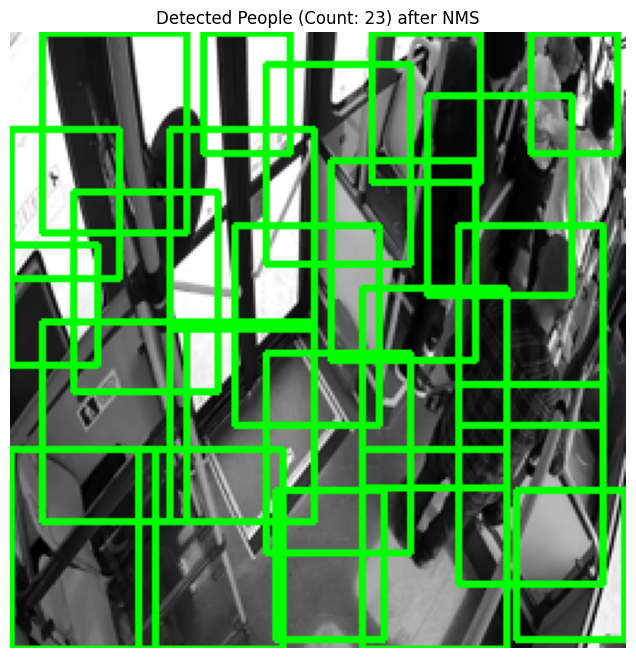

Finished visualizing detections. Total unique people detected: 23


In [ ]:
if 'imagens_preprocessadas_usuario' not in locals() or not imagens_preprocessadas_usuario:
    print("⚠️ Imagem do ônibus não disponível.")
elif 'deteccoes' not in locals() or not deteccoes:
    print("⚠️ Nenhuma detecção encontrada. Execute a célula anterior.")
else:
    imagem_onibus = imagens_preprocessadas_usuario[0]
    imagem_uint8 = (imagem_onibus * 255).astype(np.uint8)
    imagem_deteccoes = cv2.cvtColor(imagem_uint8.copy(), cv2.COLOR_GRAY2BGR)
    
    # Função NMS (Non-Maximum Suppression)
    def suprimir_nao_maximos(caixas, limiar_sobreposicao):
        if len(caixas) == 0:
            return np.array([])
        
        if caixas.dtype.kind == "i":
            caixas = caixas.astype("float")
        
        escolhidos = []
        
        x1 = caixas[:, 0]
        y1 = caixas[:, 1]
        x2 = caixas[:, 0] + caixas[:, 2]
        y2 = caixas[:, 1] + caixas[:, 3]
        
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        indices = np.argsort(y2)
        
        while len(indices) > 0:
            ultimo = len(indices) - 1
            i = indices[ultimo]
            escolhidos.append(i)
            
            xx1 = np.maximum(x1[i], x1[indices[:ultimo]])
            yy1 = np.maximum(y1[i], y1[indices[:ultimo]])
            xx2 = np.minimum(x2[i], x2[indices[:ultimo]])
            yy2 = np.minimum(y2[i], y2[indices[:ultimo]])
            
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
            
            sobreposicao = (w * h) / area[indices[:ultimo]]
            
            indices = np.delete(
                indices,
                np.concatenate(([ultimo], np.where(sobreposicao > limiar_sobreposicao)[0]))
            )
        
        return caixas[escolhidos].astype("int")
    
    # Extrair caixas
    caixas = np.array([d['box'] for d in deteccoes])
    
    # Aplicar NMS
    if len(caixas) > 0:
        caixas_filtradas = suprimir_nao_maximos(caixas, limiar_sobreposicao=0.3)
    else:
        caixas_filtradas = []
    
    # Desenhar caixas filtradas
    for (x, y, w, h) in caixas_filtradas:
        cv2.rectangle(imagem_deteccoes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Exibir
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(imagem_deteccoes, cv2.COLOR_BGR2RGB))
    plt.title(f'🎯 Pessoas Detectadas (Contagem: {len(caixas_filtradas)})')
    plt.axis('off')
    plt.show()
    
    print(f"\n✓ Resultado Final:")
    print(f"  - Detecções brutas: {len(deteccoes)}")
    print(f"  - Após NMS: {len(caixas_filtradas)}")
    print(f"  - Redução: {len(deteccoes) - len(caixas_filtradas)} caixas removidas")

---

# CONCLUSÃO

## Resumo Completo do Projeto

Neste notebook, desenvolvemos um **sistema completo de detecção de pessoas em ambientes internos de ônibus** utilizando técnicas clássicas de Visão Computacional.

## Pipeline Implementado

1. **Pré-processamento**: Carregamento e redimensionamento de imagens
2. **Extração de Características**:
   - Detecção de bordas (Canny)
   - Detecção de cantos (Harris Corner Detection)
   - **HOG (Histogram of Oriented Gradients)** - principal descriptor usado
3. **Classificação**: SVM (Support Vector Machine) com kernel linear
4. **Detecção Multi-escala**: Sliding Window em diferentes escalas
5. **Pós-processamento**: NMS (Non-Maximum Suppression) para eliminar detecções redundantes

## Resultados Obtidos

- **Modelo treinado** capaz de classificar regiões como "pessoa" ou "não-pessoa"
- **Sistema de detecção** que processa imagens completas e localiza pessoas
- **Pipeline completo** desde ROIs anotadas até detecções finais refinadas

## Próximos Passos

Para melhorar o sistema, você pode:

1. **Aumentar o dataset** com mais exemplos positivos e negativos
2. **Ajustar hiperparâmetros** do SVM e HOG
3. **Implementar data augmentation** para tornar o modelo mais robusto
4. **Testar outras técnicas** como Deep Learning (YOLO, Faster R-CNN, etc.)
5. **Otimizar performance** do sliding window e NMS

---

## Importante

**Este notebook foi reorganizado em módulos Python!**  
Para projetos reais, utilize a versão modular disponível em `ibus_ai/`.  
Consulte o `README.md` e `GUIA_DE_ESTUDO.md` para mais informações.